In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
folder_path = 'C:\\Users\\Dominik\\Python\\DS_projekt\\wig20_notowania'

df_list = []

for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(folder_path, file))
        
        # extract the file name and use it as the stock symbol
        stock_symbol = file.split("_")[0]
        
        # insert the stock symbol as a new column in the dataframe
        df.insert(0, "Stock", stock_symbol)
        
        # add the dataframe to the list
        df_list.append(df)
        
# concatenate all the dataframes into one        
df_all = pd.concat(df_list)

In [3]:
df_all.head()

,Stock,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
0,acp,1998-06-02,10.1220,10.1220,10.1220,10.1220,605100.042466
1,acp,1998-06-03,11.1207,11.1207,11.1207,11.1207,231965.123851
2,acp,1998-06-04,12.1193,12.1193,12.1193,12.1193,686991.280966
3,acp,1998-06-05,12.2654,12.2654,12.2654,12.2654,264040.169853
4,acp,1998-06-08,12.2148,12.2148,12.2148,12.2148,148527.898090


In [4]:
number_of_rows = len(df_all)
print(number_of_rows)


91808


In [20]:
def load_data(company, start, end):
    dataframe = df_all.copy()
    dataframe = dataframe.loc[dataframe.Stock == company, :]
    #convert the dataframe['Data'] column to datetime format before comparing it with start and end variables.
    dataframe['Data'] = pd.to_datetime(dataframe['Data'])
    dataframe = dataframe.loc[(dataframe['Data'] > start) & (dataframe['Data'] < end), :]
    return dataframe


In [21]:
stock_symbol = 'acp'
from_date = dt.datetime(2010,1,1)
to_date = dt.datetime(2023,1,18)

In [22]:
data = load_data(company = stock_symbol,
                 start = from_date,
                 end = to_date)

In [23]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Zamkniecie'].values.reshape(-1,1))

In [24]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [25]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [26]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [27]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
101/101 [==============================] - 16s 88ms/step - loss: 0.0068
Epoch 2/25
101/101 [==============================] - 8s 80ms/step - loss: 0.0018
Epoch 3/25
101/101 [==============================] - 8s 80ms/step - loss: 0.0017
Epoch 4/25
101/101 [==============================] - 9s 87ms/step - loss: 0.0015
Epoch 5/25
101/101 [==============================] - 9s 89ms/step - loss: 0.0016
Epoch 6/25
101/101 [==============================] - 9s 89ms/step - loss: 0.0032
Epoch 7/25
101/101 [==============================] - 9s 89ms/step - loss: 0.0022
Epoch 8/25
101/101 [==============================] - 9s 89ms/step - loss: 0.0013
Epoch 9/25
101/101 [==============================] - 9s 89ms/step - loss: 0.0013
Epoch 10/25
101/101 [==============================] - 9s 89ms/step - loss: 0.0012
Epoch 11/25
101/101 [==============================] - 9s 90ms/step - loss: 0.0010
Epoch 12/25
101/101 [==============================] - 9s 90ms/step - loss: 0.0011
Epoch 13/25


In [28]:
# test model accuracy on existing data
test_data = load_data(company = stock_symbol,
                 start = from_date,
                 end = dt.datetime.now())

actual_prices = test_data['Zamkniecie'].values

total_dataset = pd.concat((data['Zamkniecie'], test_data['Zamkniecie']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [29]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

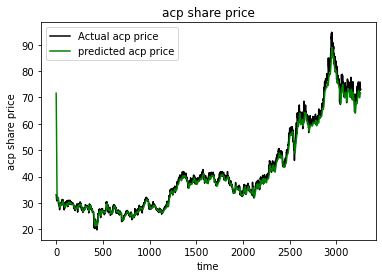

In [30]:
plt.plot(actual_prices, color='black', label=f"Actual {stock_symbol} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {stock_symbol} price")
plt.title(f"{stock_symbol} share price")
plt.xlabel("time")
plt.ylabel(f"{stock_symbol} share price")
plt.legend()
plt.show()